# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [ ]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

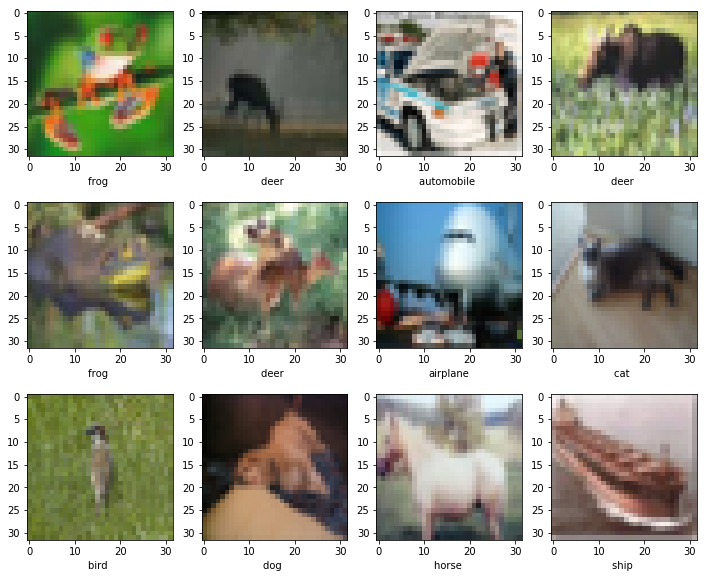

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [42]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [43]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [44]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [45]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2615, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [46]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [47]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
#opt = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss = []
val_accuracy = []

In [48]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 1.456s
  training loss (in-iteration): 	2.030823
  validation accuracy: 			32.59 %
Epoch 2 of 20 took 1.491s
  training loss (in-iteration): 	1.854284
  validation accuracy: 			35.80 %
Epoch 3 of 20 took 1.190s
  training loss (in-iteration): 	1.785913
  validation accuracy: 			37.74 %
Epoch 4 of 20 took 1.213s
  training loss (in-iteration): 	1.735028
  validation accuracy: 			39.93 %
Epoch 5 of 20 took 1.230s
  training loss (in-iteration): 	1.692559
  validation accuracy: 			39.03 %
Epoch 6 of 20 took 1.188s
  training loss (in-iteration): 	1.659472
  validation accuracy: 			42.33 %
Epoch 7 of 20 took 1.173s
  training loss (in-iteration): 	1.629500
  validation accuracy: 			43.37 %
Epoch 8 of 20 took 1.197s
  training loss (in-iteration): 	1.603637
  validation accuracy: 			43.89 %
Epoch 9 of 20 took 1.171s
  training loss (in-iteration): 	1.583899
  validation accuracy: 			43.98 %
Epoch 10 of 20 took 1.669s
  training loss (in-iteration): 	1.563659
  validation 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [9]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		47.76 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [94]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(2250,100)
        self.dropout = nn.Dropout(p = 0.1)
        self.linear_2 = nn.Linear(100, 10)
        
    
    def forward(self,x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = Flatten()(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x
    
model = Model()


In [95]:
opt = torch.optim.Adamax(model.parameters())
train_loss = []
val_accuracy = []

In [96]:
import time
num_epochs = 30 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 30 took 10.304s
  training loss (in-iteration): 	1.876795
  validation accuracy: 			40.90 %
Epoch 2 of 30 took 15.428s
  training loss (in-iteration): 	1.588946
  validation accuracy: 			46.89 %
Epoch 3 of 30 took 14.277s
  training loss (in-iteration): 	1.449258
  validation accuracy: 			50.39 %
Epoch 4 of 30 took 16.419s
  training loss (in-iteration): 	1.366302
  validation accuracy: 			53.49 %
Epoch 5 of 30 took 16.641s
  training loss (in-iteration): 	1.300994
  validation accuracy: 			54.59 %
Epoch 6 of 30 took 16.994s
  training loss (in-iteration): 	1.252481
  validation accuracy: 			55.39 %
Epoch 7 of 30 took 16.987s
  training loss (in-iteration): 	1.203231
  validation accuracy: 			56.49 %
Epoch 8 of 30 took 17.149s
  training loss (in-iteration): 	1.163074
  validation accuracy: 			58.23 %
Epoch 9 of 30 took 17.012s
  training loss (in-iteration): 	1.128991
  validation accuracy: 			58.38 %
Epoch 10 of 30 took 16.738s
  training loss (in-iteration): 	1.095706
  v

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [97]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        
        self.bn2 = nn.BatchNorm2d(10)
        self.bn1_1 = nn.BatchNorm1d(2250)
        self.bn1_2 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(2250,100)
        self.dropout = nn.Dropout(p = 0.1)
        self.linear_2 = nn.Linear(100, 10)
        
    
    def forward(self,x):
        x = self.conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = Flatten()(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x
    
model = Model()
model(torch.tensor(X_train[0:2], dtype = torch.float32)).shape

torch.Size([2, 10])

In [98]:
opt = torch.optim.Adamax(model.parameters(), lr=0.01)
train_loss = []
val_accuracy = []

In [99]:
import time
num_epochs = 30 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 30 took 20.177s
  training loss (in-iteration): 	1.416335
  validation accuracy: 			55.76 %
Epoch 2 of 30 took 25.041s
  training loss (in-iteration): 	1.139483
  validation accuracy: 			58.44 %
Epoch 3 of 30 took 24.903s
  training loss (in-iteration): 	1.019203
  validation accuracy: 			61.98 %
Epoch 4 of 30 took 24.428s
  training loss (in-iteration): 	0.925483
  validation accuracy: 			60.51 %
Epoch 5 of 30 took 23.551s
  training loss (in-iteration): 	0.851188
  validation accuracy: 			59.09 %
Epoch 6 of 30 took 21.296s
  training loss (in-iteration): 	0.791656
  validation accuracy: 			62.47 %
Epoch 7 of 30 took 21.817s
  training loss (in-iteration): 	0.740874
  validation accuracy: 			63.30 %
Epoch 8 of 30 took 20.487s
  training loss (in-iteration): 	0.685828
  validation accuracy: 			65.17 %
Epoch 9 of 30 took 19.731s
  training loss (in-iteration): 	0.647438
  validation accuracy: 			60.52 %
Epoch 10 of 30 took 20.591s
  training loss (in-iteration): 	0.611618
  v

In [104]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        
        self.bn2 = nn.BatchNorm2d(10)
        self.bn1_1 = nn.BatchNorm1d(2250)
        self.bn1_2 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(2250,100)
        self.dropout = nn.Dropout(p = 0.1)
        self.linear_2 = nn.Linear(100, 10)
        
    
    def forward(self,x):
        x = self.conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = Flatten()(x)
        #x = self.bn1_1(x)
        #x = self.relu(x)
        x = self.linear(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x
    
model = Model()
model(torch.tensor(X_train[0:2], dtype = torch.float32)).shape

torch.Size([2, 10])

In [105]:
opt = torch.optim.Adamax(model.parameters(), lr=0.01)
train_loss = []
val_accuracy = []

In [106]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 12.992s
  training loss (in-iteration): 	1.390418
  validation accuracy: 			54.09 %
Epoch 2 of 100 took 12.799s
  training loss (in-iteration): 	1.118508
  validation accuracy: 			50.22 %
Epoch 3 of 100 took 14.019s
  training loss (in-iteration): 	0.990250
  validation accuracy: 			64.20 %
Epoch 4 of 100 took 14.925s
  training loss (in-iteration): 	0.889403
  validation accuracy: 			52.81 %
Epoch 5 of 100 took 16.292s
  training loss (in-iteration): 	0.808600
  validation accuracy: 			61.32 %
Epoch 6 of 100 took 16.342s
  training loss (in-iteration): 	0.739647
  validation accuracy: 			61.15 %
Epoch 7 of 100 took 18.087s
  training loss (in-iteration): 	0.671689
  validation accuracy: 			61.33 %
Epoch 8 of 100 took 13.738s
  training loss (in-iteration): 	0.621330
  validation accuracy: 			62.52 %
Epoch 9 of 100 took 13.226s
  training loss (in-iteration): 	0.576338
  validation accuracy: 			60.32 %
Epoch 10 of 100 took 13.672s
  training loss (in-iteration): 	0.

Epoch 80 of 100 took 12.555s
  training loss (in-iteration): 	0.110745
  validation accuracy: 			61.20 %
Epoch 81 of 100 took 12.592s
  training loss (in-iteration): 	0.111144
  validation accuracy: 			61.35 %
Epoch 82 of 100 took 12.658s
  training loss (in-iteration): 	0.109203
  validation accuracy: 			61.11 %
Epoch 83 of 100 took 12.494s
  training loss (in-iteration): 	0.110425
  validation accuracy: 			59.09 %
Epoch 84 of 100 took 12.612s
  training loss (in-iteration): 	0.110496
  validation accuracy: 			61.57 %
Epoch 85 of 100 took 12.591s
  training loss (in-iteration): 	0.111199
  validation accuracy: 			61.33 %
Epoch 86 of 100 took 12.586s
  training loss (in-iteration): 	0.109009
  validation accuracy: 			60.77 %
Epoch 87 of 100 took 12.557s
  training loss (in-iteration): 	0.108603
  validation accuracy: 			60.83 %
Epoch 88 of 100 took 12.552s
  training loss (in-iteration): 	0.108380
  validation accuracy: 			61.75 %
Epoch 89 of 100 took 12.687s
  training loss (in-iterat


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [108]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [109]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

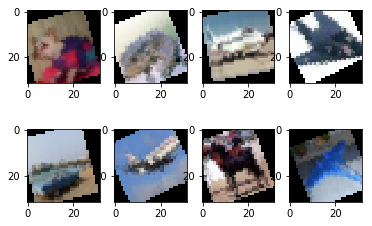

In [110]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [112]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

#test_loader = <YOUR CODE>
test_loader = CIFAR10("./cifar_data/", train = False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

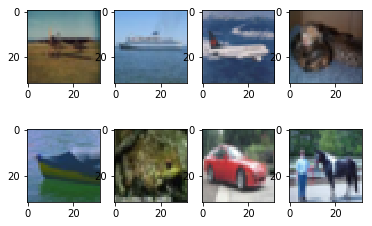

In [114]:
for (x_batch, y_batch) in test_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    raise NotImplementedError("Plese use this code in your training loop")

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [143]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding = 1)
        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding = 1)
        self.pool = nn.MaxPool2d(2)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.relu = nn.LeakyReLU(0.1)
        self.bn1_1 = nn.BatchNorm1d(8192)
        self.bn1_2 = nn.BatchNorm1d(512)
        self.linear = nn.Linear(8192,512)
        self.linear_2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p = 0.1)
        
        
    
    def forward(self,x):
        x = self.dropout(x)
        x = self.conv(x)
        x = self.bn2_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = self.bn2_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = Flatten()(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x
    
model = Model()
model(torch.tensor(X_train[0:2], dtype = torch.float32)).shape

torch.Size([2, 10])

In [144]:
opt = torch.optim.Adamax(model.parameters(), lr=0.01)
train_loss = []
val_accuracy = []

# Эксперимент 1 

In [130]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 258.949s
  training loss (in-iteration): 	1.330472
  validation accuracy: 			47.88 %
Epoch 2 of 100 took 273.299s
  training loss (in-iteration): 	1.030302
  validation accuracy: 			40.78 %
Epoch 3 of 100 took 289.690s
  training loss (in-iteration): 	0.885403
  validation accuracy: 			57.04 %
Epoch 4 of 100 took 369.447s
  training loss (in-iteration): 	0.762602
  validation accuracy: 			48.93 %
Epoch 5 of 100 took 363.812s
  training loss (in-iteration): 	0.664904
  validation accuracy: 			54.21 %
Epoch 6 of 100 took 327.918s
  training loss (in-iteration): 	0.558598
  validation accuracy: 			65.92 %
Epoch 7 of 100 took 281.283s
  training loss (in-iteration): 	0.483812
  validation accuracy: 			67.00 %
Epoch 8 of 100 took 317.206s
  training loss (in-iteration): 	0.412147
  validation accuracy: 			64.53 %
Epoch 9 of 100 took 266.342s
  training loss (in-iteration): 	0.350513
  validation accuracy: 			69.07 %
Epoch 10 of 100 took 264.674s
  training loss (in-itera

KeyboardInterrupt: 

# Эксперимент 2 - таже сеть, только с аугоментацией

In [145]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in test_batch_gen:
        logits = model(Variable(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        y_batch = y_batch.data
        val_accuracy.append(np.mean(y_batch.data.numpy() == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 478.152s
  training loss (in-iteration): 	1.455688
  validation accuracy: 			52.39 %
Epoch 2 of 100 took 356.727s
  training loss (in-iteration): 	1.310795
  validation accuracy: 			59.48 %
Epoch 3 of 100 took 338.213s
  training loss (in-iteration): 	1.233577
  validation accuracy: 			63.47 %
Epoch 4 of 100 took 324.171s
  training loss (in-iteration): 	1.182935
  validation accuracy: 			61.11 %
Epoch 5 of 100 took 339.774s
  training loss (in-iteration): 	1.149951
  validation accuracy: 			65.94 %
Epoch 6 of 100 took 342.284s
  training loss (in-iteration): 	1.122735
  validation accuracy: 			63.06 %
Epoch 7 of 100 took 329.484s
  training loss (in-iteration): 	1.088522
  validation accuracy: 			66.45 %
Epoch 8 of 100 took 342.578s
  training loss (in-iteration): 	1.064644
  validation accuracy: 			69.09 %
Epoch 9 of 100 took 381.752s
  training loss (in-iteration): 	1.050802
  validation accuracy: 			69.31 %
Epoch 10 of 100 took 363.896s
  training loss (in-itera

Epoch 79 of 100 took 326.265s
  training loss (in-iteration): 	0.760288
  validation accuracy: 			77.17 %
Epoch 80 of 100 took 336.635s
  training loss (in-iteration): 	0.765844
  validation accuracy: 			77.81 %
Epoch 81 of 100 took 336.855s
  training loss (in-iteration): 	0.765785
  validation accuracy: 			76.77 %
Epoch 82 of 100 took 297.362s
  training loss (in-iteration): 	0.757939
  validation accuracy: 			76.05 %
Epoch 83 of 100 took 316.411s
  training loss (in-iteration): 	0.766998
  validation accuracy: 			77.05 %
Epoch 84 of 100 took 299.866s
  training loss (in-iteration): 	0.763642
  validation accuracy: 			75.78 %
Epoch 85 of 100 took 305.110s
  training loss (in-iteration): 	0.751511
  validation accuracy: 			78.77 %
Epoch 86 of 100 took 337.875s
  training loss (in-iteration): 	0.750855
  validation accuracy: 			77.48 %
Epoch 87 of 100 took 315.322s
  training loss (in-iteration): 	0.748928
  validation accuracy: 			76.77 %
Epoch 88 of 100 took 337.491s
  training loss 